In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
# Unpacking h5 arrays into numpy arrays
filename = 'letters52.h5'
with h5py.File(filename , 'r') as h:
    df = np.array(h['letters'])
    x = []
    for i in range(len(df)):
        x.append(df[i])
    plt.imshow(x[6])

In [2]:
# Import the ResNet model and remove the classification layer
import keras
from keras.models import Model
brain = 'resnet'
outsize = 0
if brain is 'resnet':
    model = keras.applications.resnet.ResNet50(weights='imagenet')
    # Remove classification layer
    model.layers.pop()
    model2 = Model(model.input, model.layers[-1].output)
    outsize = 2048

Using TensorFlow backend.


In [3]:
# Predict outputs from the ResNet model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
y = []
for i in range(len(x)):
    newx = np.expand_dims(x[i], axis=0)
    newx = preprocess_input(x[i])
    x[i] = newx.reshape(1,224,224,3)
    newy = model2.predict(x[i])
    newy = newy.reshape(len(x[i]),outsize)
    y.append(newy)
x = np.array(x)
y = np.array(y).reshape(len(y),outsize)

In [4]:
# Use PCA to flatten the high-dimensional predictions onto a 2-D plane
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(y)
yt = pca.transform(y)

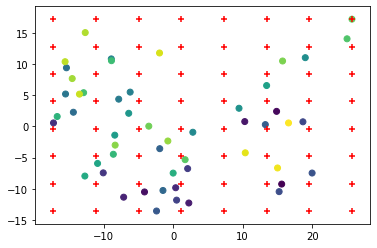

In [5]:
# Grid plotting
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
from scipy.optimize import linear_sum_assignment
mx = min(yt[:,0])
Mx = max(yt[:,0])
my = min(yt[:,1])
My = max(yt[:,1])
grid = []
h = 8
w = 8
for i in range(h):
    for j in range(w):
        grid.append([mx+(Mx-mx)/(w-1)*j,my+(My-my)/(h-1)*i])
grid = np.array(grid)
# Uncomment below to see original points and grid markers
plt.scatter(yt[:,0],yt[:,1], c=range(0,len(yt)))
plt.scatter(grid[:,0],grid[:,1],c='red',marker='+')
plt.show()

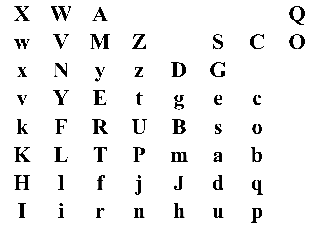

In [6]:
# Use linear sum assignment to assign a grid position to each image
pts = yt
mat = np.zeros(shape=(w*h,w*h))
for row in range(len(grid)):
    for col in range(len(pts)):
        mat[row,col] = np.linalg.norm(pts[col]-grid[row])
row_ind,col_ind = linear_sum_assignment(mat)
assigned = []
for num in row_ind:
    assigned.append(grid[num])
assigned = np.array(assigned)
fig, ax = plt.subplots()
ax.scatter(assigned[:,0],assigned[:,1],c='white')
#ax.set_ylim(-32,32)
ax.set_aspect('equal','box')
for x0,y0,i in zip(assigned[:,0],assigned[:,1], col_ind):
    if i < len(df):
        ab = AnnotationBbox(OffsetImage(df[i],zoom=0.085), (x0, y0), frameon=False)
        ax.add_artist(ab)
plt.axis('off')
plt.savefig('out_Alphabet.png',bbox_inches='tight',dpi=300)
plt.show()

In [7]:
# 2-Means clustering on the predicted high-dimensional vectors
from sklearn.cluster import KMeans
classes = KMeans(n_clusters=3,random_state=1).fit_predict(y)
#classes
#plt.scatter(yt[:,0],yt[:,1], c=classes, cmap='rainbow')
#plt.show()

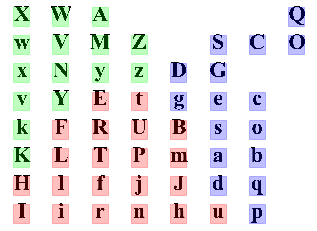

In [8]:
# Color arrangement based on classes
cols = [(1,0,0,0.25),(0,0,1,0.25),(0,1,0,0.25),(1,0,1,0.25),(1,1,0,0.25),(0,1,1,0.25)]
fig, ax = plt.subplots()
ax.scatter(assigned[:,0],assigned[:,1],c='white')
#ax.set_ylim(-32,32)
ax.set_aspect('equal','box')
for x0,y0,i in zip(assigned[:,0],assigned[:,1], col_ind):
    if i < len(df):
        ab = AnnotationBbox(OffsetImage(df[i],zoom=0.085), (x0, y0), frameon=False)
        col = AnnotationBbox(TextArea('  ',textprops=dict(backgroundcolor=cols[classes[i]],size=11)),
                             (x0,y0),frameon=False)
        ax.add_artist(ab)
        ax.add_artist(col)
plt.axis('off')
plt.savefig('out_Alphabet_cluster.png',bbox_inches='tight',dpi=300)
plt.show()

In [9]:
# Generating strings based on these "classes of letters"
r = list('EtFRUBLTPmHlfjJIirnhu ')
g = list('XWAwVMZxNyzvYkK ')
b = list('QSCODGgecsoabdqb ')
print('Language 1:')
print(''.join(np.random.choice(r,99)))
print('Language 2:')
print(''.join(np.random.choice(g,99)))
print('Language 3:')
print(''.join(np.random.choice(b,99)))

Language 1:
IHEhtjH BrRjjh uPlPlRIujBrruiffFmfLiHluFRlFIlmFmhtERTFFmffnlUhhhLrrjrmLPnJTLJPfEJfLUTEIfnEImLhIt Ju
Language 2:
ZZwwKN kvMMvwwVVYwvMYKMkAkzM MxWwWwkkVykAXNVAWxWAN  WvzyVyVYzMNVzYx xYyN AyVKAzzXM  xWKxNXNkkyzZkxz
Language 3:
gCqQseoGbOoQCbebSbG DecQSqQGaadOGSaGqoaOaoQbboOgdCdCCdcbScCSQ bCeDGO  ccoebDgeS qDdoDCecqQSoOocGsSC
